# G16 data

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Read in data from specified .csv file
df = pd.read_csv('New camera image data - Sheet1.csv')
data = df.values

## Comment in/out next line to see formatting of data ###
# print(df.loc[0,'Electron Energy'])

In [3]:
# print(df.loc[0,:])

In [58]:
### Constants ###
N = len(df.index)   # number of images in Powershot G16 Data
H_V_lattice = 3.493569812  #Reciprocal distance between Horizontal and Vertical Cu100 lattice points
D_lattice = 2.470326905    #Reciprocal distance between Diagonal Cu100 lattice points

In [59]:
## Data Values from dataframe ##
energy = df.loc[:,'Electron Energy']
sqrtE = np.sqrt(energy)
opening_m = df.loc[:,'Opening']
opening_m_error = np.std(opening_m)/opening_m

In [60]:
####### H V D dataframes
#select columns of interest
hcols = ['H_Xpeak_1', 'H_Half max left_1', 'H_Half max right_1', 'H_Xpeak_2', 'H_Half max left_2', 'H_Half max right_2']
vcols = ['V_Xpeak_1', 'V_Half max left_1', 'V_Half max right_1', 'V_Xpeak_2', 'V_Half max left_2', 'V_Half max right_2']
dcols = ['D_Xpeak_1', 'D_Half max left_1', 'D_Half max right_1', 'D_Xpeak_2', 'D_Half max left_2', 'D_Half max right_2']

#select wanted portions of main dataframe
H_df = df[hcols]
V_df = df[vcols]
D_df = df[dcols]

##### fix the first few data points of the Diagonal data
D_df.loc[[0,1,2,3,4],'D_Xpeak_1'] = .5*D_df.loc[[0,1,2,3,4],'D_Xpeak_1']
D_df.loc[[0,1,2,3,4],'D_Xpeak_2'] = .5*D_df.loc[[0,1,2,3,4],'D_Xpeak_2']
# print(D_df.loc[[0,1,2,3,4],'D_Xpeak_2'] - D_df.loc[[0,1,2,3,4], 'D_Xpeak_1'])

In [8]:
### Calculated Values ###
#Screen opening and opening error
def recip_openingANDerror(lattice, data, Opening_A, Error_opening_AU):
    spacing_AU = data.iloc[:,3] - data.iloc[:,0]         #Calculate distance between points (Right_x_position - Left_x_position)
    opening = lattice*(Opening_A/spacing_AU)   #Calculate opening size in reciprocal space (lattice spacing*(Opening[AU]/Lattice spacing[AU]))
    d_left = .5*(data.iloc[:,2] - data.iloc[:,1])        #absolute error in left point .5*(width of peak at half max)
    d_right = .5*(data.iloc[:,5] - data.iloc[:,4])       #absolute error in right point .5*(width of peak at half max)
    d_spacing = np.sqrt(np.square(d_left) + np.square(d_right))   #absolute error in spacing (addition of absolute error in quadrature)
    frac_error = np.sqrt(np.square(d_spacing/spacing_AU) + np.square(Error_opening_AU/Opening_A))   #fractional error in spacing
    error_recip = frac_error*opening           #fractional error in opening calculation
    return opening, error_recip

#least squares fit with error in slope and intercept
##details of calculation in next cell
def w_lst_sq(opening_recip, error_recip, e_energy, sqrt_e):
    weights = 1/np.square(error_recip)         #weights for line fit from error in opening
    Delta = np.sum(weights)*np.sum(weights*e_energy)-np.square(np.sum(weights*sqrt_e))
    intercept = ((np.sum(weights*e_energy)*np.sum(weights*opening_recip))
                 -(np.sum(weights*sqrt_e)*np.sum(weights*sqrt_e*opening_recip)))/Delta
    slope = (np.sum(weights)*np.sum(weights*sqrt_e*opening_recip)-np.sum(weights*sqrt_e)*np.sum(weights*opening_recip))/Delta
    intercept_error = np.sqrt(np.sum(weights*e_energy)/Delta)
    slope_error = np.sqrt(np.sum(weights)/Delta)
    return slope, slope_error, intercept, intercept_error

$$ B = \frac{\sum{w  E} \sum{w  O} - \sum w\sqrt{E} \sum w O \sqrt{E} }{\Delta} $$

$$ A = \frac{\sum{w} \sum{w O \sqrt{E}}-\sum{w\sqrt e} \sum{w O}}{\Delta} $$

Where 
$$ \Delta = \sum{w} \sum{w E}- (\sum w\sqrt{e})^2 $$
And 
$$ Y = Ax + B $$

In [64]:
H_recip_opening, H_opening_error = recip_openingANDerror(H_V_lattice, H_df, opening_m, opening_m_error)
H_slope, H_slope_error, H_intercept, H_intercept_error = w_lst_sq(H_recip_opening, H_opening_error, energy, sqrtE)
print('H Slope + error', H_slope, H_slope_error, 'Intercept + error:', H_intercept, H_intercept_error)

V_recip_opening, V_opening_error = recip_openingANDerror(H_V_lattice, V_df, opening_m, opening_m_error)
V_slope, V_slope_error, V_intercept, V_intercept_error = w_lst_sq(V_recip_opening, V_opening_error, energy, sqrtE)
print('V Slope + error', V_slope, V_slope_error, 'Intercept + error:', V_intercept, V_intercept_error)

D_recip_opening, D_opening_error = recip_openingANDerror(D_lattice, D_df, opening_m, opening_m_error)
D_slope, D_slope_error, D_intercept, D_intercept_error = w_lst_sq(D_recip_opening, D_opening_error, energy, sqrtE)
print('D Slope + error', D_slope, D_slope_error, 'Intercept + error:', D_intercept, D_intercept_error)

H Slope + error 0.7702071387066763 0.03752820129150288 Intercept + error: 0.5130240351966252 0.3349668602467557
V Slope + error 0.7650675038207839 0.04814540132896146 Intercept + error: 0.6314761751409919 0.43293008006211614
D Slope + error 0.7776123059603269 0.05714997235386788 Intercept + error: 0.498209224988452 0.5071268144172828


# Old camera data

In [65]:
#Read in data from old camera, same format as above
df2 = pd.read_csv('Old Camera image data - Sheet1.csv')
data2 = df2.values

In [66]:
### Data Values ###
#all values same format as above
N2 = len(df2.index)
energy2 = df2.loc[:,'Electron Energy']
sqrtE2 = np.sqrt(energy2)
opening_m2 = df2.loc[:,'Opening']
opening_m_error2 = np.std(opening_m2)/opening_m2

### Sections of data
H_df2 = df2[hcols]
# print(H_data[0,:])
V_df2 = df2[vcols]
# print(V_data[:,3])
D_df2 = df2[dcols]
# print(D_df2.loc[0][:])

# G7X mkII data

In [15]:
#Read in data
df3 = pd.read_csv('G7XmkII image data - Sheet1.csv')
data3 = df3.values

In [36]:
### Data Values ###
N3 = len(df3.index) # number of images
energy3 = df3.loc[:,'Electron Energy']
sqrtE3 = np.sqrt(energy3)
opening_m3 = df3.loc[:,'Opening']
opening_m_error3 = np.std(opening_m3)/opening_m3

### Sections of data
H_df3 = df3[hcols]
# print(H_df3.loc[0][:])
V_df3 = df3[vcols]
# print(V_df3.loc[0][:])
D_df3 = df3[dcols]     ### The data points for the 5 lowset energies couldn't be measured diagonally
# print(D_df3.loc[6][:]) 

## Spacing calculations

In [22]:
#Calculate reciprocal spacing between measured points using fit line
def spacing_calc(energy, meas_opening, data, direction, camera='1'):
    meas_spacing = data.iloc[:,3] - data.iloc[:,0]
    ratio = meas_spacing/meas_opening
    if camera == '1':
        if direction == 'H':
            opening_func = H_slope*np.sqrt(energy) + H_intercept
        elif direction == 'V':
            opening_func = V_slope*np.sqrt(energy) + V_intercept
        elif direction == 'D':
            opening_func = D_slope*np.sqrt(energy) + D_intercept
    elif camera == '2':
        if direction == 'H':
            opening_func = H_slope2*np.sqrt(energy) + H_intercept2
        elif direction == 'V':
            opening_func = V_slope2*np.sqrt(energy) + V_intercept2
        elif direction == 'D':
            opening_func = D_slope2*np.sqrt(energy) + D_intercept2
    else:
        print('Please re-run cell and select a valid direction and camera')
    
    spacing = ratio*opening_func
    return spacing

In [67]:
### Calculate reciprocal spacing between measured points using line fit from G16 data
## H fits
#G16 Data
HH1_spacing = spacing_calc(energy, opening_m, H_df, 'H')
HV1_spacing = spacing_calc(energy, opening_m, V_df, 'H')
HD1_spacing = spacing_calc(energy, opening_m, D_df, 'H')
#Old camera data
HH2_spacing = spacing_calc(energy2, opening_m2, H_df2, 'H')
HV2_spacing = spacing_calc(energy2, opening_m2, V_df2, 'H')
HD2_spacing = spacing_calc(energy2, opening_m2, D_df2, 'H')
#G7X mkII data
HH3_spacing = spacing_calc(energy3, opening_m3, H_df3, 'H')
HV3_spacing = spacing_calc(energy3, opening_m3, V_df3, 'H')
HD3_spacing = spacing_calc(energy3, opening_m3, D_df3, 'H')

## V fits
#G16 Data
VH1_spacing = spacing_calc(energy, opening_m, H_df, 'V')
VV1_spacing = spacing_calc(energy, opening_m, V_df, 'V')
VD1_spacing = spacing_calc(energy, opening_m, D_df, 'V')
#Old camera data
VH2_spacing = spacing_calc(energy2, opening_m2, H_df2, 'V')
VV2_spacing = spacing_calc(energy2, opening_m2, V_df2, 'V')
VD2_spacing = spacing_calc(energy2, opening_m2, D_df2, 'V')
#G7X mkII data
VH3_spacing = spacing_calc(energy3, opening_m3, H_df3, 'V')
VV3_spacing = spacing_calc(energy3, opening_m3, V_df3, 'V')
VD3_spacing = spacing_calc(energy3, opening_m3, D_df3, 'V')

## D fits
#G16 Data
DH1_spacing = spacing_calc(energy, opening_m, H_df, 'D')
DV1_spacing = spacing_calc(energy, opening_m, V_df, 'D')
DD1_spacing = spacing_calc(energy, opening_m, D_df, 'D')
#Old camera data
DH2_spacing = spacing_calc(energy2, opening_m2, H_df2, 'D')
DV2_spacing = spacing_calc(energy2, opening_m2, V_df2, 'D')
DD2_spacing = spacing_calc(energy2, opening_m2, D_df2, 'D')
#G7X mkII data
DH3_spacing = spacing_calc(energy3, opening_m3, H_df3, 'D')
DV3_spacing = spacing_calc(energy3, opening_m3, V_df3, 'D')
DD3_spacing = spacing_calc(energy3, opening_m3, D_df3, 'D')

## Error calculations

In [24]:
### Following calculations are just for looking at components of error calculations

#Calculate spacing between measured points in Arbitrary Units and fractional error
def spacing_AU(data):  
    meas_spacing = data.iloc[:,3] - data.iloc[:,0]
    spacing_frac_error = np.sqrt(np.square(.5*(data.iloc[:,2] - data.iloc[:,1]))
                                 + np.square(.5*(data.iloc[:,5] - data.iloc[:,4])))/meas_spacing
    return meas_spacing, spacing_frac_error

#Fractional error in line fit parameters A and B
def frac_axb(A, d_A, B, d_B, sqrt_e):
    frac = np.sqrt(np.square(sqrt_e*d_A) + np.square(d_B))/(A*sqrt_e + B)
    return frac

#Calculate fractional error in opening calculation from line fit
def frac_error(frac_ab, frac_open, data): 
    meas_spacing = data.iloc[:,3] - data.iloc[:,0]
    spacing_frac_error = np.sqrt(np.square(.5*(data.iloc[:,2] - data.iloc[:,1])) + np.square(.5*(data.iloc[:,5] - data.iloc[:,4])))/meas_spacing
    tot_frac_error = np.sqrt(np.square(frac_ab) + np.square(frac_open) + np.square(spacing_frac_error))
    return tot_frac_error

In [25]:
#calculate total error in calculated spacing
    # calculate measured spacing [AU]
    #  "  fractional error in measured spacing [%]
    #  "  fractional error in selected line fit [%]
    #  "  total fractional error [%]
    #  "  total error in calculated spacing [A^-1]
def tot_error(direction, sqrt_e, frac_open, data, spacing, camera='1'):
    meas_spacing = data.iloc[:,3] - data.iloc[:,0]
    spacing_frac_error = np.sqrt(np.square(.5*(data.iloc[:,2] - data.iloc[:,1])) + np.square(.5*(data.iloc[:,5] - data.iloc[:,4])))/meas_spacing
    if camera == '1':
        if direction == 'H':
            frac_ab = np.sqrt(np.square(sqrt_e*H_slope_error) + np.square(H_intercept_error))/(H_slope*sqrt_e + H_intercept)
        elif direction == 'V':
            frac_ab = np.sqrt(np.square(sqrt_e*V_slope_error) + np.square(V_intercept_error))/(V_slope*sqrt_e + V_intercept)
        elif direction == 'D':
            frac_ab = np.sqrt(np.square(sqrt_e*D_slope_error) + np.square(D_intercept_error))/(D_slope*sqrt_e + D_intercept)
    elif camera == '2':
        if direction == 'H':
            frac_ab = np.sqrt(np.square(sqrt_e*H_slope_error2) + np.square(H_intercept_error2))/(H_slope2*sqrt_e + H_intercept2)
        elif direction == 'V':
            frac_ab = np.sqrt(np.square(sqrt_e*V_slope_error2) + np.square(V_intercept_error2))/(V_slope2*sqrt_e + V_intercept2)
        elif direction == 'D':
            frac_ab = np.sqrt(np.square(sqrt_e*D_slope_error2) + np.square(D_intercept_error2))/(D_slope2*sqrt_e + D_intercept2)
    else:
        print('Please re-run cell and select a valid direction and camera')
        
    tot_frac_error = np.sqrt(np.square(frac_ab) + np.square(frac_open) + np.square(spacing_frac_error))
    tot_error = tot_frac_error*spacing
    return tot_error

In [77]:
#Total absolute error in reciprocal spacing
HH1_error = tot_error('H', sqrtE, opening_m_error, H_df, HH1_spacing)
HV1_error = tot_error('H', sqrtE, opening_m_error, V_df, HV1_spacing)
HD1_error = tot_error('H', sqrtE, opening_m_error, D_df, HD1_spacing)
HH2_error = tot_error('H', sqrtE2, opening_m_error2, H_df2, HH2_spacing)
HV2_error = tot_error('H', sqrtE2, opening_m_error2, V_df2, HV2_spacing)
HD2_error = tot_error('H', sqrtE2, opening_m_error2, D_df2, HD2_spacing)
HH3_error = tot_error('H', sqrtE3, opening_m_error3, H_df3, HH3_spacing)
HV3_error = tot_error('H', sqrtE3, opening_m_error3, V_df3, HV3_spacing)
HD3_error = tot_error('H', sqrtE3, opening_m_error3, D_df3, HD3_spacing)

VH1_error = tot_error('V', sqrtE, opening_m_error, H_df, VH1_spacing)
VV1_error = tot_error('V', sqrtE, opening_m_error, V_df, VV1_spacing)
VD1_error = tot_error('V', sqrtE, opening_m_error, D_df, VD1_spacing)
VH2_error = tot_error('V', sqrtE2, opening_m_error2, H_df2, VH2_spacing)
VV2_error = tot_error('V', sqrtE2, opening_m_error2, V_df2, VV2_spacing)
VD2_error = tot_error('V', sqrtE2, opening_m_error2, D_df2, VD2_spacing)
VH3_error = tot_error('V', sqrtE3, opening_m_error3, H_df3, VH3_spacing)
VV3_error = tot_error('V', sqrtE3, opening_m_error3, V_df3, VV3_spacing)
VD3_error = tot_error('V', sqrtE3, opening_m_error3, D_df3, VD3_spacing)

DH1_error = tot_error('D', sqrtE, opening_m_error, H_df, DH1_spacing)
DV1_error = tot_error('D', sqrtE, opening_m_error, V_df, DV1_spacing)
DD1_error = tot_error('D', sqrtE, opening_m_error, D_df, DD1_spacing)
DH2_error = tot_error('D', sqrtE2, opening_m_error2, H_df2, DH2_spacing)
DV2_error = tot_error('D', sqrtE2, opening_m_error2, V_df2, DV2_spacing)
DD2_error = tot_error('D', sqrtE2, opening_m_error2, D_df2, DD2_spacing)
DH3_error = tot_error('D', sqrtE3, opening_m_error3, H_df3, DH3_spacing)
DV3_error = tot_error('D', sqrtE3, opening_m_error3, V_df3, DV3_spacing)
DD3_error = tot_error('D', sqrtE3, opening_m_error3, D_df3, DD3_spacing)

# Plot theoretical spacing vs energy
### for old camera data using new camera line fit

In [69]:
x1 = sqrtE
x2 = sqrtE2
x3 = sqrtE3

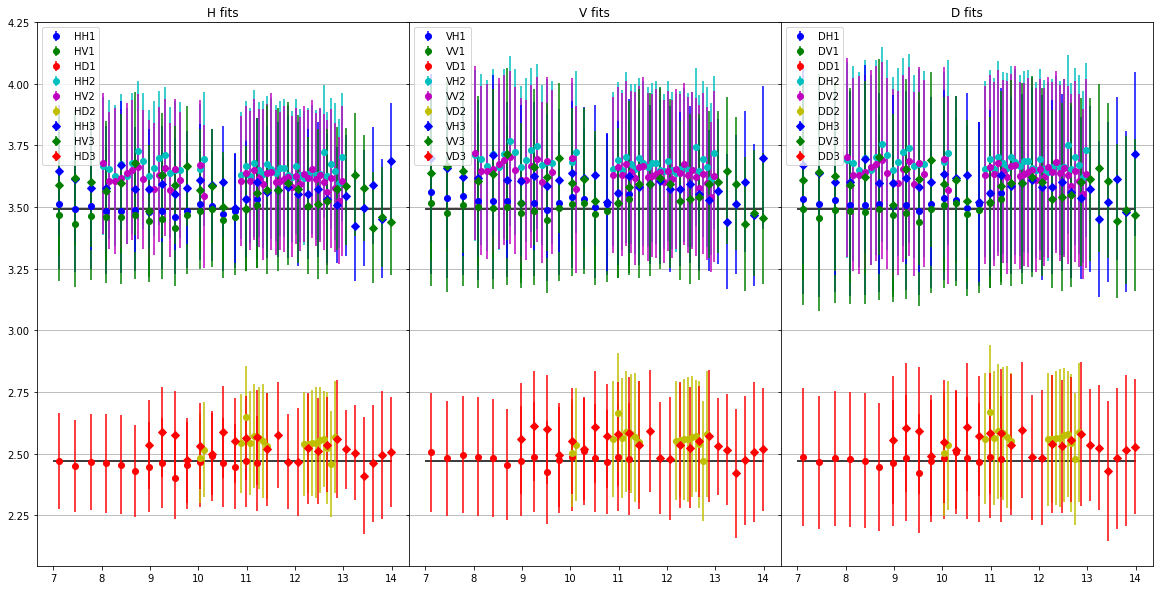

In [79]:
#Compare all plots in a row
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True)

#figure settings
f.set_figheight(10)
f.set_figwidth(20)
f.subplots_adjust(wspace=0)

#subplot settings
ax1.set_title('H fits')
ax1.grid(which='major', axis='y')
ax2.set_title('V fits')
ax2.grid(which='major', axis='y')
ax3.set_title('D fits')
ax3.grid(which='major', axis='y')

#add horizontal lines on all 3 subplots
ax1.hlines(H_V_lattice, 7, 14)
ax1.hlines(D_lattice, 7, 14)
ax2.hlines(H_V_lattice, 7, 14)
ax2.hlines(D_lattice, 7, 14)
ax3.hlines(H_V_lattice, 7, 14)
ax3.hlines(D_lattice, 7, 14)

## Compare data sets using H fit
ax1.errorbar(x1, HH1_spacing, yerr=HH1_error, ls='none', color='b', label='HH1', marker='o')
ax1.errorbar(x1, HV1_spacing, yerr=HV1_error, ls='none', color='g', label='HV1', marker='o')
ax1.errorbar(x1, HD1_spacing, yerr=HD1_error, ls='none', color='r', label='HD1', marker='o')

ax1.errorbar(x2, HH2_spacing, yerr=HH2_error, ls='none', color='c', label='HH2', marker='o')
ax1.errorbar(x2, HV2_spacing, yerr=HV2_error, ls='none', color='m', label='HV2', marker='o')
ax1.errorbar(x2, HD2_spacing, yerr=HD2_error, ls='none', color='y', label='HD2', marker='o')

ax1.errorbar(x3, HH3_spacing, yerr=HH3_error, ls='none', color='b', label='HH3', marker='D')
ax1.errorbar(x3, HV3_spacing, yerr=HV3_error, ls='none', color='g', label='HV3', marker='D')
ax1.errorbar(x3, HD3_spacing, yerr=HD3_error, ls='none', color='r', label='HD3', marker='D')

## Compare data sets using V fit
ax2.errorbar(x1, VH1_spacing, yerr=VH1_error, ls='none', color='b', label='VH1', marker='o')
ax2.errorbar(x1, VV1_spacing, yerr=VV1_error, ls='none', color='g', label='VV1', marker='o')
ax2.errorbar(x1, VD1_spacing, yerr=VD1_error, ls='none', color='r', label='VD1', marker='o')

ax2.errorbar(x2, VH2_spacing, yerr=VH2_error, ls='none', color='c', label='VH2', marker='o')
ax2.errorbar(x2, VV2_spacing, yerr=VV2_error, ls='none', color='m', label='VV2', marker='o')
ax2.errorbar(x2, VD2_spacing, yerr=VD2_error, ls='none', color='y', label='VD2', marker='o')

ax2.errorbar(x3, VH3_spacing, yerr=VH3_error, ls='none', color='b', label='VH3', marker='D')
ax2.errorbar(x3, VV3_spacing, yerr=VV3_error, ls='none', color='g', label='VV3', marker='D')
ax2.errorbar(x3, VD3_spacing, yerr=VD3_error, ls='none', color='r', label='VD3', marker='D')

## Compare data sets using D fit
ax3.errorbar(x1, DH1_spacing, yerr=DH1_error, ls='none', color='b', label='DH1', marker='o')
ax3.errorbar(x1, DV1_spacing, yerr=DV1_error, ls='none', color='g', label='DV1', marker='o')
ax3.errorbar(x1, DD1_spacing, yerr=DD1_error, ls='none', color='r', label='DD1', marker='o')

ax3.errorbar(x2, DH2_spacing, yerr=DH2_error, ls='none', color='c', label='DH2', marker='o')
ax3.errorbar(x2, DV2_spacing, yerr=DV2_error, ls='none', color='m', label='DV2', marker='o')
ax3.errorbar(x2, DD2_spacing, yerr=DD2_error, ls='none', color='y', label='DD2', marker='o')

ax3.errorbar(x3, DH3_spacing, yerr=DH3_error, ls='none', color='b', label='DH3', marker='D')
ax3.errorbar(x3, DV3_spacing, yerr=DV3_error, ls='none', color='g', label='DV3', marker='D')
ax3.errorbar(x3, DD3_spacing, yerr=DD3_error, ls='none', color='r', label='DD3', marker='D')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

### Let's try using a line fit from the old camera data

In [61]:
H_recip_opening2, H_opening_error2 = recip_openingANDerror(H_V_lattice, H_df2, opening_m2, opening_m_error2)
H_slope2, H_slope_error2, H_intercept2, H_intercept_error2 = w_lst_sq(H_recip_opening2, H_opening_error2, energy2, sqrtE2)
print('H2 Slope + error', H_slope2, H_slope_error2, 'Intercept + error:', H_intercept2, H_intercept_error2)

V_recip_opening2, V_opening_error2 = recip_openingANDerror(H_V_lattice, V_df2, opening_m2, opening_m_error2)
V_slope2, V_slope_error2, V_intercept2, V_intercept_error2 = w_lst_sq(V_recip_opening2, V_opening_error2, energy2, sqrtE2)
print('V2 Slope + error', V_slope2, V_slope_error2, 'Intercept + error:', V_intercept2, V_intercept_error2)

D_recip_opening2, D_opening_error2 = recip_openingANDerror(D_lattice, D_df2, opening_m2, opening_m_error2)
D_slope2, D_slope_error2, D_intercept2, D_intercept_error2 = w_lst_sq(D_recip_opening2, D_opening_error2, energy2, sqrtE2)
print('D2 Slope + error', D_slope2, D_slope_error2, 'Intercept + error:', D_intercept2, D_intercept_error2)

H2 Slope + error 0.7450509407315528 0.03496458430385925 Intercept + error: 0.3958839587416572 0.35507815509211427
V2 Slope + error 0.7567304040763512 0.03876958187180256 Intercept + error: 0.36716247068388375 0.39257126154226196
D2 Slope + error 0.7237889322718783 0.13504215369112085 Intercept + error: 0.7785442978388312 1.544440394801995


In [ ]:
##### notes about error from old camera data #####
# d2 slope and intercept error is really large (2-3 times larger than H/V)
# this error comes from the error in the calculated spacing and the error in the opening size
# opening error is the same for all directions
# spacing error for diagonal is much higher than H or V

# H and V have really low error, probably due to data collection differences
# technique improved/changed after collecting the data
# spacing error is measured, must be different/better?
# maybe diagonal data is less reliable in general?

In [71]:
# Calculate reciprocal spacing between points using old camera line fit
# specifiy old camera using optional arg camera = '2' after direction arg
# H fits
HH1_spacing2 = spacing_calc(energy, opening_m, H_df, 'H', '2')
HV1_spacing2 = spacing_calc(energy, opening_m, V_df, 'H', '2')
HD1_spacing2 = spacing_calc(energy, opening_m, D_df, 'H', '2')
HH2_spacing2 = spacing_calc(energy2, opening_m2, H_df2, 'H', '2')
HV2_spacing2 = spacing_calc(energy2, opening_m2, V_df2, 'H', '2')
HD2_spacing2 = spacing_calc(energy2, opening_m2, D_df2, 'H', '2')
# V fits
VH1_spacing2 = spacing_calc(energy, opening_m, H_df, 'V', '2')
VV1_spacing2 = spacing_calc(energy, opening_m, V_df, 'V', '2')
VD1_spacing2 = spacing_calc(energy, opening_m, D_df, 'V', '2')
VH2_spacing2 = spacing_calc(energy2, opening_m2, H_df2, 'V', '2')
VV2_spacing2 = spacing_calc(energy2, opening_m2, V_df2, 'V', '2')
VD2_spacing2 = spacing_calc(energy2, opening_m2, D_df2, 'V', '2')
# D fits
DH1_spacing2 = spacing_calc(energy, opening_m, H_df, 'D', '2')
DV1_spacing2 = spacing_calc(energy, opening_m, V_df, 'D', '2')
DD1_spacing2 = spacing_calc(energy, opening_m, D_df, 'D', '2')
DH2_spacing2 = spacing_calc(energy2, opening_m2, H_df2, 'D', '2')
DV2_spacing2 = spacing_calc(energy2, opening_m2, V_df2, 'D', '2')
DD2_spacing2 = spacing_calc(energy2, opening_m2, D_df2, 'D', '2')

In [74]:
# calculate total absolute error in spacing calculation
# select old camera using optional arg camera = '2'
HH1_error2 = tot_error('H', sqrtE, opening_m_error, H_df, HH1_spacing2, '2')
HV1_error2 = tot_error('H', sqrtE, opening_m_error, V_df, HV1_spacing2, '2')
HD1_error2 = tot_error('H', sqrtE, opening_m_error, D_df, HD1_spacing2, '2')
HH2_error2 = tot_error('H', sqrtE2, opening_m_error2, H_df2, HH2_spacing2, '2')
HV2_error2 = tot_error('H', sqrtE2, opening_m_error2, V_df2, HV2_spacing2, '2')
HD2_error2 = tot_error('H', sqrtE2, opening_m_error2, D_df2, HD2_spacing2, '2')

VH1_error2 = tot_error('V', sqrtE, opening_m_error, H_df, VH1_spacing2, '2')
VV1_error2 = tot_error('V', sqrtE, opening_m_error, V_df, VV1_spacing2, '2')
VD1_error2 = tot_error('V', sqrtE, opening_m_error, D_df, VD1_spacing2, '2')
VH2_error2 = tot_error('V', sqrtE2, opening_m_error2, H_df2, VH2_spacing2, '2')
VV2_error2 = tot_error('V', sqrtE2, opening_m_error2, V_df2, VV2_spacing2, '2')
VD2_error2 = tot_error('V', sqrtE2, opening_m_error2, D_df2, VD2_spacing2, '2')

DH1_error2 = tot_error('D', sqrtE, opening_m_error, H_df, DH1_spacing2, '2')
DV1_error2 = tot_error('D', sqrtE, opening_m_error, V_df, DV1_spacing2, '2')
DD1_error2 = tot_error('D', sqrtE, opening_m_error, D_df, DD1_spacing2, '2')
DH2_error2 = tot_error('D', sqrtE2, opening_m_error2, H_df2, DH2_spacing2, '2')
DV2_error2 = tot_error('D', sqrtE2, opening_m_error2, V_df2, DV2_spacing2, '2')
DD2_error2 = tot_error('D', sqrtE2, opening_m_error2, D_df2, DD2_spacing2, '2')

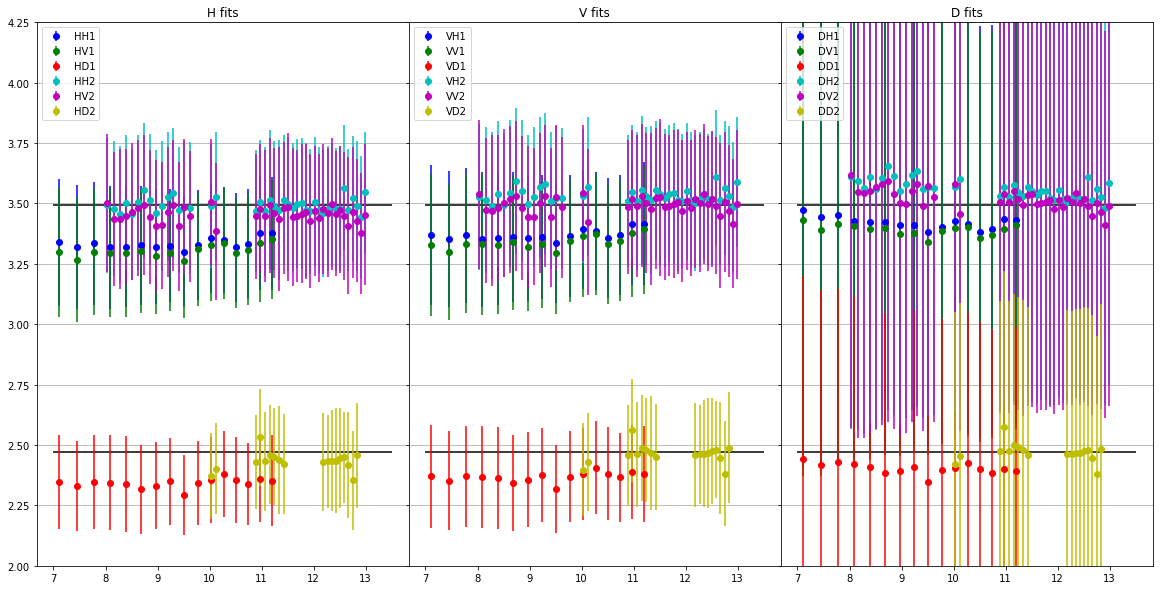

In [99]:
#Compare all plots in a row
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True)

#figure settings
f.set_figheight(10)
f.set_figwidth(20)
f.subplots_adjust(wspace=0)
plt.ylim(2,4.25)
#subplot settings
ax1.set_title('H fits')
ax1.grid(which='major', axis='y')
ax2.set_title('V fits')
ax2.grid(which='major', axis='y')
ax3.set_title('D fits')
ax3.grid(which='major', axis='y')

#add horizontal lines on all 3 subplots
ax1.hlines(H_V_lattice, 7, 13.5)
ax1.hlines(D_lattice, 7, 13.5)
ax2.hlines(H_V_lattice, 7, 13.5)
ax2.hlines(D_lattice, 7, 13.5)
ax3.hlines(H_V_lattice, 7, 13.5)
ax3.hlines(D_lattice, 7, 13.5)

# Compare data sets using H fit
ax1.errorbar(x1, HH1_spacing2, yerr=HH1_error2, ls='none', color='b', label='HH1', marker='o')
ax1.errorbar(x1, HV1_spacing2, yerr=HV1_error2, ls='none', color='g', label='HV1', marker='o')
ax1.errorbar(x1, HD1_spacing2, yerr=HD1_error2, ls='none', color='r', label='HD1', marker='o')

ax1.errorbar(x2, HH2_spacing2, yerr=HH2_error2, ls='none', color='c', label='HH2', marker='o')
ax1.errorbar(x2, HV2_spacing2, yerr=HV2_error2, ls='none', color='m', label='HV2', marker='o')
ax1.errorbar(x2, HD2_spacing2, yerr=HD2_error2, ls='none', color='y', label='HD2', marker='o')

# Compare data sets using V fit
ax2.errorbar(x1, VH1_spacing2, yerr=VH1_error2, ls='none', color='b', label='VH1', marker='o')
ax2.errorbar(x1, VV1_spacing2, yerr=VV1_error2, ls='none', color='g', label='VV1', marker='o')
ax2.errorbar(x1, VD1_spacing2, yerr=VD1_error2, ls='none', color='r', label='VD1', marker='o')

ax2.errorbar(x2, VH2_spacing2, yerr=VH2_error2, ls='none', color='c', label='VH2', marker='o')
ax2.errorbar(x2, VV2_spacing2, yerr=VV2_error2, ls='none', color='m', label='VV2', marker='o')
ax2.errorbar(x2, VD2_spacing2, yerr=VD2_error2, ls='none', color='y', label='VD2', marker='o')

# Compare data sets using D fit
ax3.errorbar(x1, DH1_spacing2, yerr=DH1_error2, ls='none', color='b', label='DH1', marker='o')
ax3.errorbar(x1, DV1_spacing2, yerr=DV1_error2, ls='none', color='g', label='DV1', marker='o')
ax3.errorbar(x1, DD1_spacing2, yerr=DD1_error2, ls='none', color='r', label='DD1', marker='o')

ax3.errorbar(x2, DH2_spacing2, yerr=DH2_error2, ls='none', color='c', label='DH2', marker='o')
ax3.errorbar(x2, DV2_spacing2, yerr=DV2_error2, ls='none', color='m', label='DV2', marker='o')
ax3.errorbar(x2, DD2_spacing2, yerr=DD2_error2, ls='none', color='y', label='DD2', marker='o')


ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')

In [ ]:
# it seems that the error from the two data sets is comparable
# the line fit from the new camera fits that data better, and the old camera fits it's data better
# the old diagonal fit has HUGE error -- due to the actual data, not the calculation
# g16 has more consistent error in line fit, but its a little larger
# g16 has lower data point error though